**How to approach a supervised learning problem:**

1. Do some EDA.
2. Build a baseline model.
3. Do more EDA.
4. Engineer features.
5. Build a better model.

# 1

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/test.csv
/kaggle/input/train.csv
/kaggle/input/gender_submission.csv


In [2]:
# import datasets
df_train = pd.read_csv("../input/train.csv") 
df_test = pd.read_csv("../input/test.csv") 

# view first five lines of training data
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


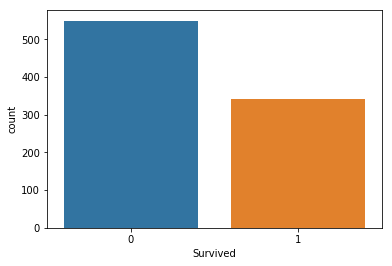

In [6]:
# plot of count(Survived)
sns.countplot(x="Survived", data=df_train)
plt.show()

More than 500 people didn't survive.

A few over 300 people survived.

So, we will predict that nobody survived as base model.

In [7]:
no_survived = pd.Series([0] * df_test.shape[0])

In [8]:
out = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': no_survived})

In [9]:
out.to_csv('no_survival.csv', index=False)

Accuracy: 62.7

# 2

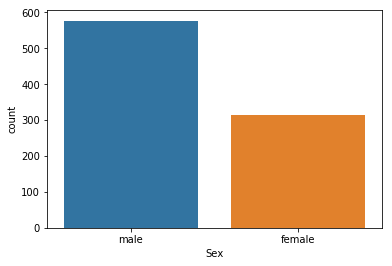

In [10]:
# plot count of male and female on titanic
sns.countplot(x="Sex", data=df_train);

There are more than 575 male and a little over 300 females, so let's check survival according to gender.

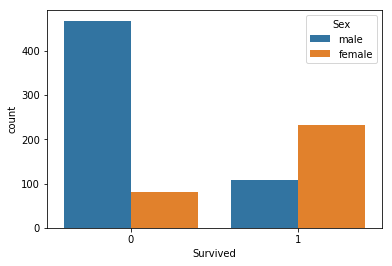

In [11]:
sns.countplot(x="Survived", hue='Sex', data=df_train);

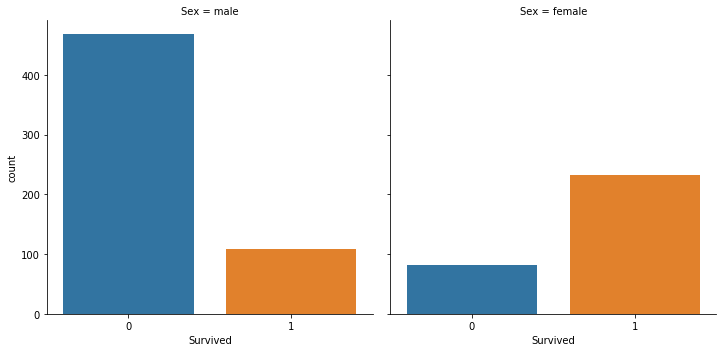

In [12]:
sns.catplot(x="Survived", col="Sex", kind="count", data=df_train);

We can see out of 300 female passengers, more than 200 survived whereas out of 600 male passengers about 100 survived.

**Take Away:** Women were more likely to survive than men.

In [13]:
df_train.groupby(['Sex']).Survived.sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

In [14]:
df_train.groupby(["Sex"]).Survived.value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [15]:
print(df_train[df_train["Sex"]=="female"].Survived.sum() / df_train[df_train["Sex"]=="female"].shape[0]) 
# print(df_train[df_train["Sex"]=="female"].Survived.sum() / df_train[df_train["Sex"]=="female"].count()) 
print(df_train[df_train["Sex"]=="male"].Survived.sum() / df_train[df_train["Sex"]=="male"].shape[0]) 

0.7420382165605095
0.18890814558058924


About 74% of women survived and only 19% men survived.

Let's build a model that predicts all womens survived and no male survived.

In [16]:
women_survived_series = pd.Series(list(map(int, df_test["Sex"]=="female")))

In [17]:
out = pd.DataFrame({"PassengerId": df_test.PassengerId, "Survived": women_survived_series})
out.to_csv('all_women_survived.csv', index=False)